In [2]:
import matplotlib.pyplot as plt
import numpy as np

from physics.sound_propagation import *

# import matplotlib.colors as mcolors
# colors = list(mcolors.TABLEAU_COLORS.keys())

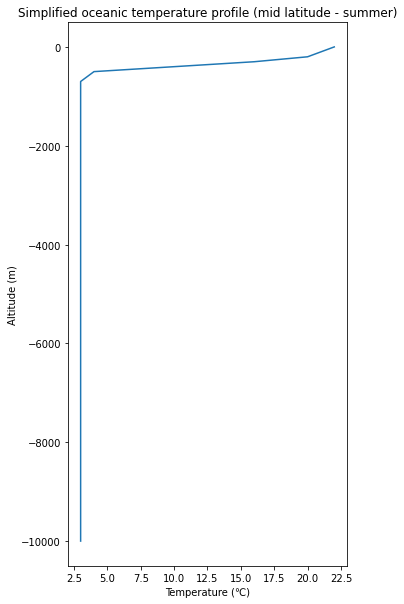

In [3]:
# from https://archive.bigelow.org/shipmates/octemp.html
temp_profile = np.array([
    [0, 22],
    [100, 21],
    [200, 20],
    [300, 16],
    [400, 10],
    [500, 4],
    [600, 3.5],
    [700, 3],
    [800, 3],
    [900, 3],
    [1000, 3],
    [1100, 3],
    [1200, 3],
    [1300, 3],
    [1400, 3],
    [1500, 3],
    [10000, 3]
])

plt.figure(figsize=(5, 10))
plt.plot(temp_profile[:, 1], -1 * temp_profile[:, 0])
plt.xlabel('Temperature (℃)')
plt.ylabel('Altitude (m)')
plt.title('Simplified oceanic temperature profile (mid latitude - summer)')
plt.show()


temperature = temp_profile.T
temperature[0] *= -1

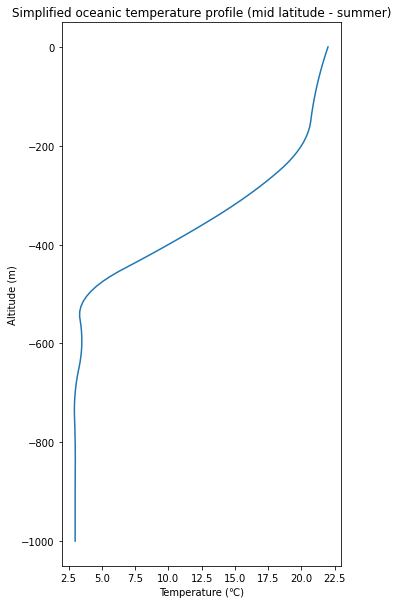

In [89]:
from scipy import interpolate
calc_T = interpolate.interp1d(temperature[0][::-1], temperature[1][::-1], kind='quadratic')

z = np.linspace(-1000, 0, 100)[::-1]
plt.figure(figsize=(5, 10))
plt.plot(calc_T(z), z)
plt.xlabel('Temperature (℃)')
plt.ylabel('Altitude (m)')
plt.title('Simplified oceanic temperature profile (mid latitude - summer)')
plt.show()

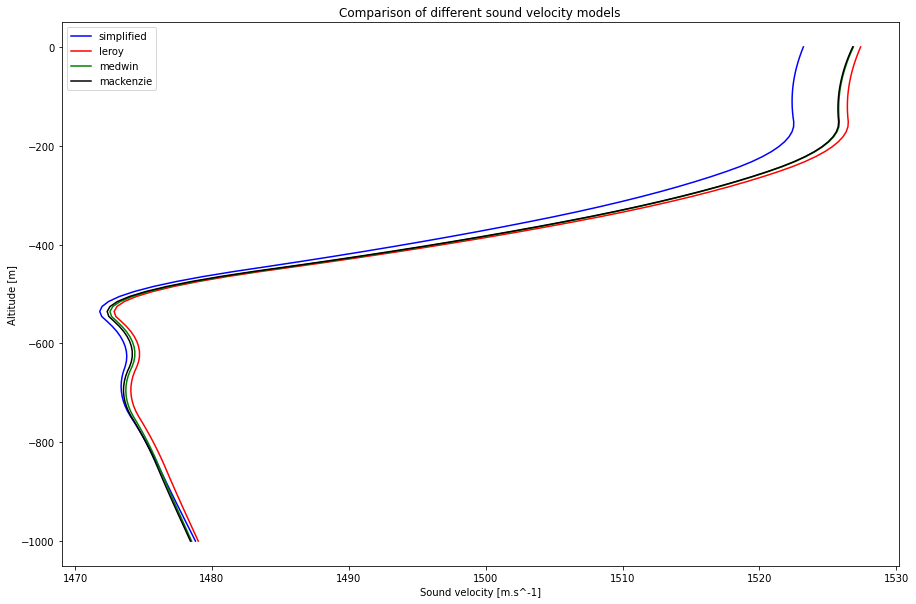

In [161]:
S = 35
z = np.linspace(-1000, 0, 100)#[::-1]
T = calc_T(z)

c_simplified = sound_velocity_simplified(S, T, z)
c_leroy      = sound_velocity_leroy     (S, T, z)
c_medwin     = sound_velocity_medwin    (S, T, z)
c_mackenzie  = sound_velocity_mackenzie (S, T, z)


plt.figure(figsize=(15, 10))

plt.plot(c_simplified, z, c='blue', label='simplified')
plt.plot(c_leroy, z, c='red', label='leroy')
plt.plot(c_medwin, z, c='green', label='medwin')
plt.plot(c_mackenzie, z, c='black', label='mackenzie')

plt.legend()
plt.title('Comparison of different sound velocity models')
plt.xlabel('Sound velocity [m.s^-1]')
plt.ylabel('Altitude [m]')
plt.show()

In [162]:
ground_profile = np.array([
    [0, -1000],
    [500, -1500],
    [1000, -1250],
    [1500, -2000],
    [2000, -3000],
    [2100, -5000],
    [2150, -2400],
    [2500, -2300],
    [3000, -3310],
    [5000, -4000],
    [5030, -2400],
    [5080, -2430],
    [6012, -3200],
    [10000, -3100],
    [20000, -2893],
    [40000, -2450],
    [80000, -2638],
    [200000, -2500]
])

ground_profile = ground_profile.T
calc_ground_z = interpolate.interp1d(ground_profile[0], ground_profile[1], kind='linear')
# calc_ground_z = interpolate.interp1d(ground_profile[0], ground_profile[1], kind='quadratic')

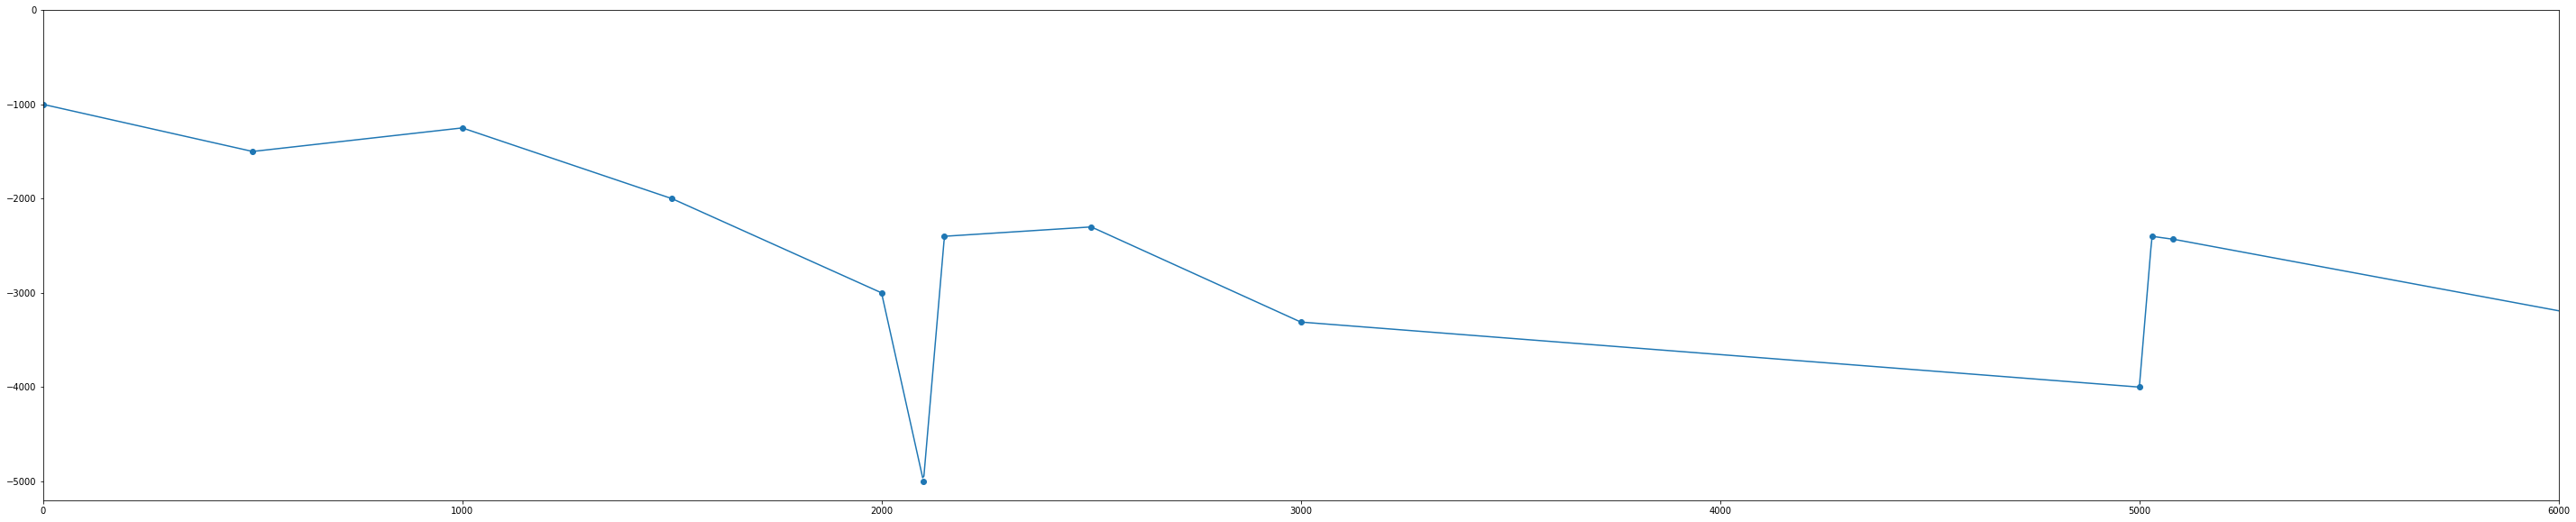

In [132]:
plt.figure(figsize=(50, 10))
X = np.linspace(0, 6000, 2000)
plt.plot(X, calc_ground_z(X))
plt.scatter(ground_profile[0], ground_profile[1])
plt.ylim(top=0)
plt.xlim((X[0], X[-1]))
plt.show()

In [118]:
# Calculate c and g
S = 35

def calc_c (z):
    return sound_velocity_medwin(S, calc_T(z), z)

z = np.linspace(-10000, 0, 10000)
c = calc_c(z)
dz_c = np.gradient(c)
calc_dz_c = interpolate.interp1d(z, dz_c, kind='quadratic')

# z_fine = np.linspace(-1000, 0, 10000)
# plt.figure(figsize=(15, 10))
# plt.plot(calc_dz_c(z_fine), z_fine)
# plt.show()

# plt.figure(figsize=(15, 10))
# plt.plot(c, z)
# plt.show()

In [135]:
from scipy.optimize import fsolve

def sound_curve (n_steps, step_z, x0, z0, theta_0, limit_top_val, limit_bottom_func):
    # Initialise differential solver parameters
    c0      = calc_c(0)
    mult   = -1 * np.power(c0 / np.sin(theta_0), 2)  # differential equation multiplier
    X = np.array([x0, ])
    Z = np.array([z0, ])
    dx_z   = 1 / np.tan(theta_0)
    dxdx_z = 0  # no initial curvature


    for i in range(n_steps):
        x = X[i]
        z = Z[i]

        # Calculate point
        dz = np.sign(dx_z) * step_z
        dx = dz / dx_z

        x_new = x + dx
        z_new = z + dz
        if z_new > limit_top_val:
            z_new = limit_top_val
            x_new = x + (limit_top_val - z) / dx_z
            dx_z *= -1

        elif z_new < limit_bottom_func(x_new):
            def g(x1): return limit_bottom_func(x) - dx_z * (x1 - x) - z
            x_new = float(fsolve(g, x0=x))
            z_new = limit_bottom_func(x_new)
            dx_z *= -1  # assuming horizontal reflection

        if x_new < x: break

        X = np.concatenate((X, np.array([x_new, ])), axis=0)
        Z = np.concatenate((Z, np.array([z_new, ])), axis=0)

        # Calculate new point's properties
        c = calc_c(z)
        g = calc_dz_c(z)

        dxdx_z = mult * g / np.power(c, 3)
        dx_z  += dxdx_z * dx

    return np.array(X), np.array(Z)


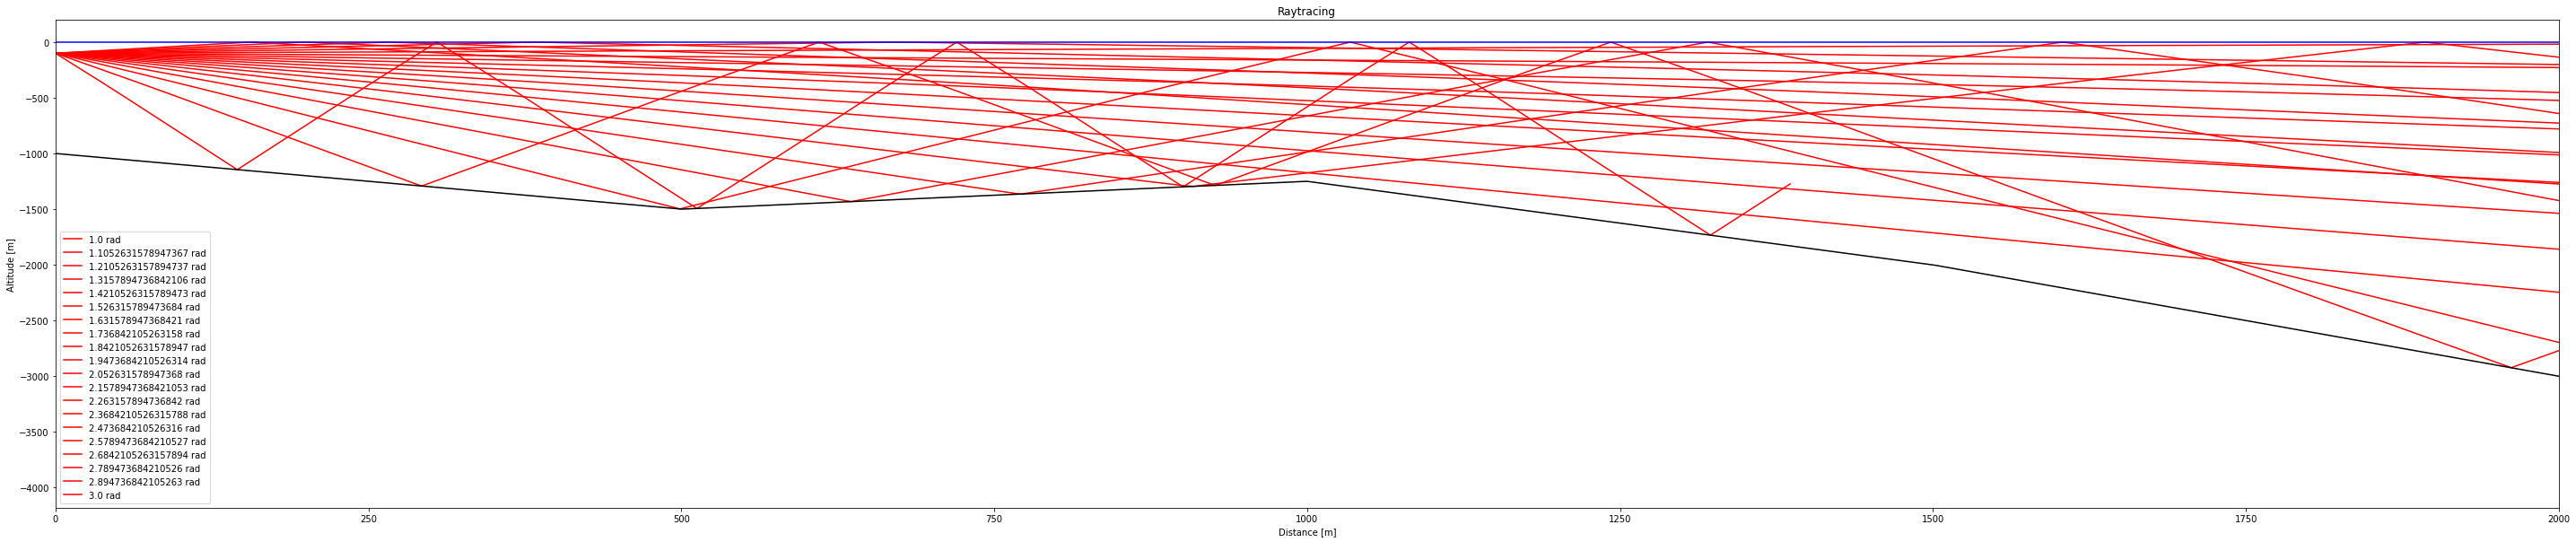

In [151]:
LIMIT_TOP = 0  # in m
# def LIMIT_BOTTOM (x): return -0.1 * x - 1000 # return np.ones_like(x) * -1000
LIMIT_BOTTOM = calc_ground_z

n_steps = 1000
step_z = 10

# Initial conditions
x0      = 0
z0      = -100
theta_0 = 3.14/2 -0.1  #in radians


thetas = np.linspace(1, 3, 20)  #np.linspace(0.2, 3, 5)


plt.figure(figsize=(50, 10))

for theta_0 in thetas:
    X, Z = sound_curve(n_steps, step_z, x0, z0, theta_0, LIMIT_TOP, LIMIT_BOTTOM)
    plt.plot(X, Z, c='red', label=f'{theta_0} rad')


x_lim = (0, 2000)
plt.plot(x_lim, (0, 0), c='blue')
x_linspace = np.linspace(x_lim[0], x_lim[1], 1000)
plt.plot(x_linspace, LIMIT_BOTTOM(x_linspace), c='black')
plt.xlim(x_lim)

plt.title('Raytracing')
plt.xlabel('Distance [m]')
plt.ylabel('Altitude [m]')
plt.legend()
plt.show()

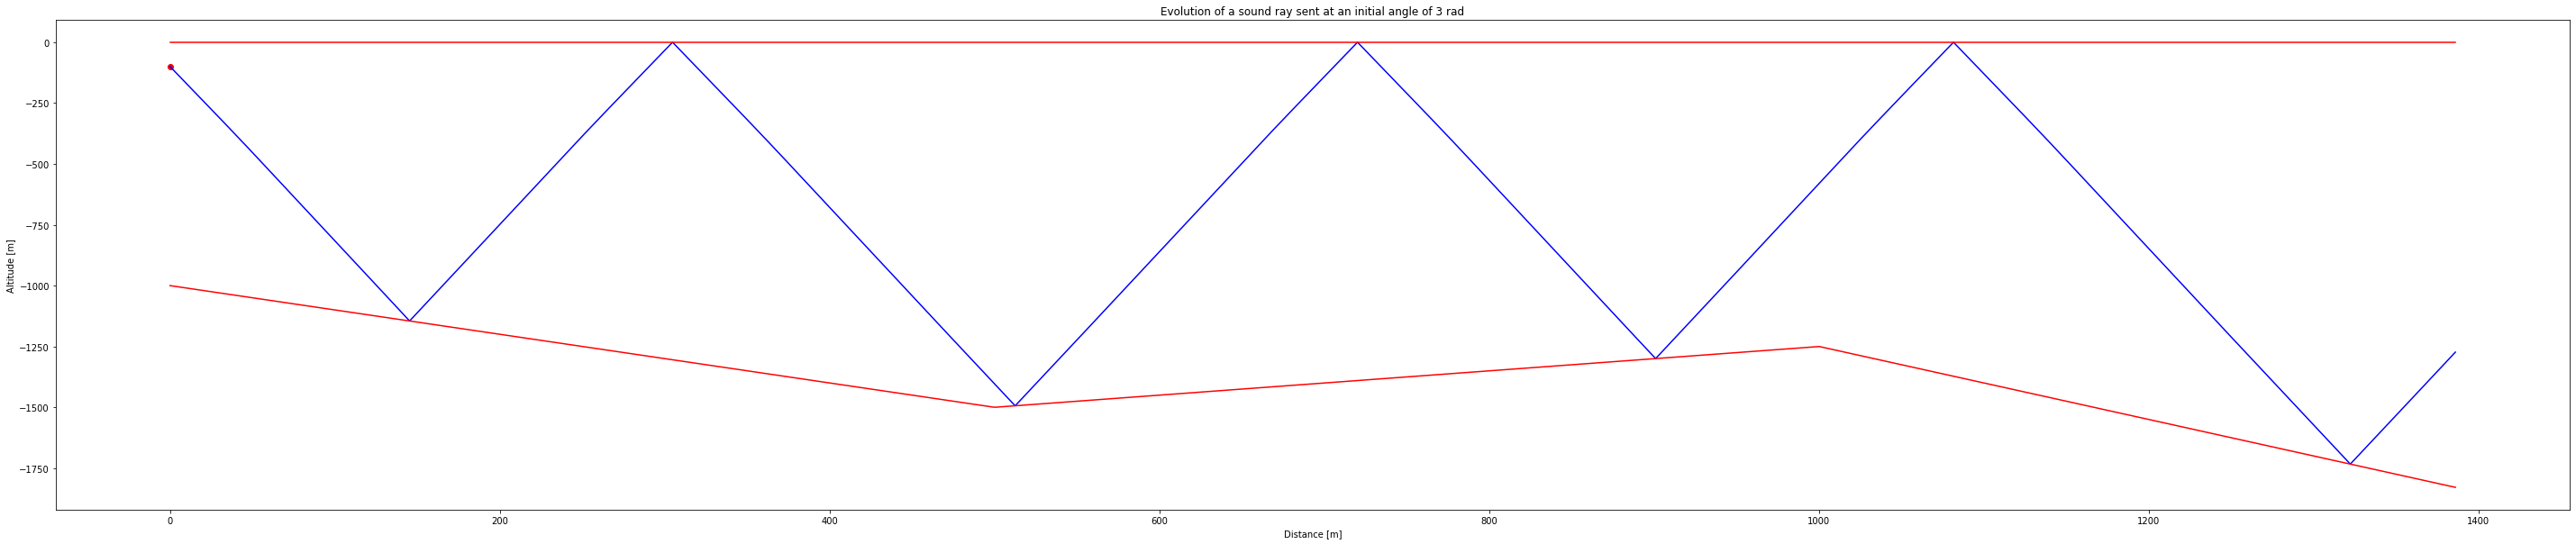

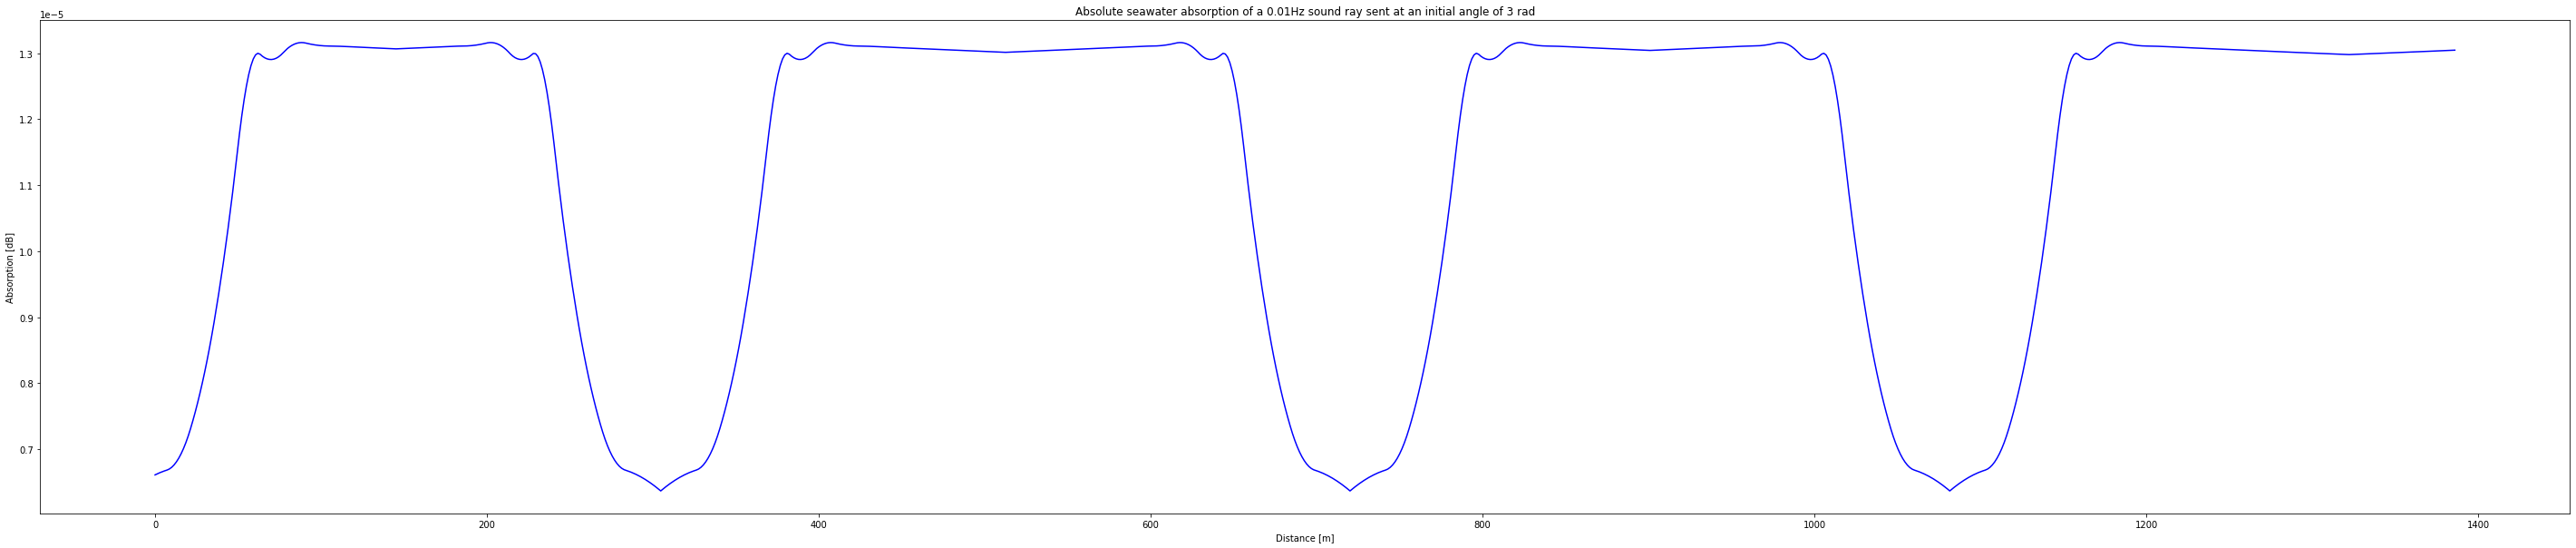

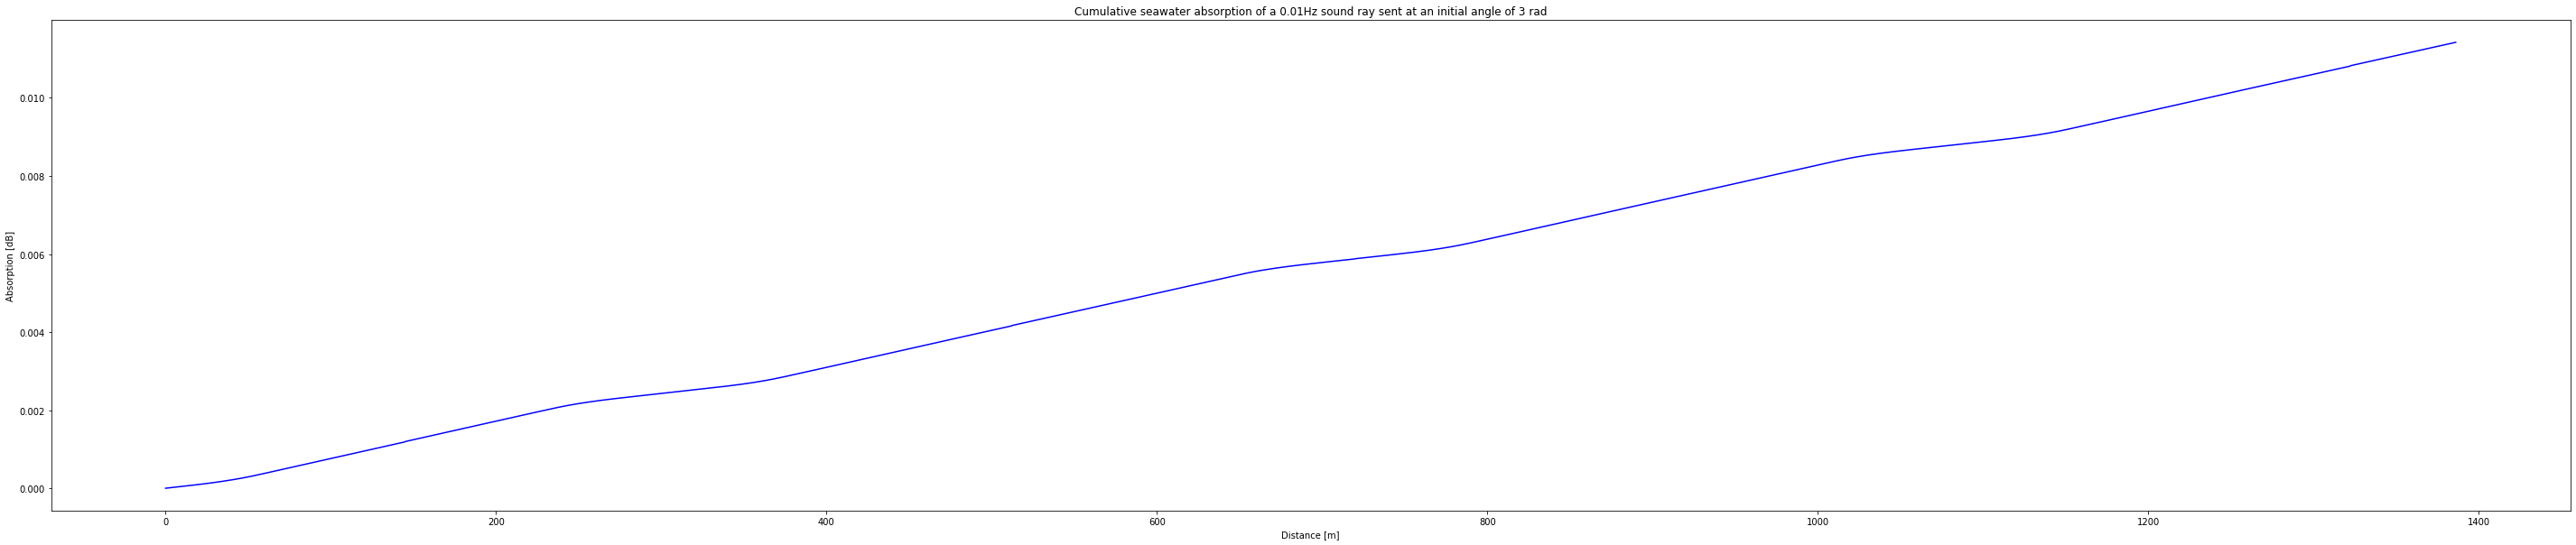

In [167]:
from absorption import absorption

x0 = 0
z0 = -100
theta_0 = 3
X, Z = sound_curve(n_steps, step_z, x0, z0, theta_0, LIMIT_TOP, LIMIT_BOTTOM)

f = 0.01  # in kHz
pH = 8
A = absorption(f, -0.001 * Z, calc_T(Z), S, 8)


plt.figure(figsize=(50, 10))
plt.plot(X, Z, c='blue')
plt.scatter(x0, z0, c='red')
plt.plot((X[0], X[-1]), (0, 0), c='red')
plt.plot(X, LIMIT_BOTTOM(X), c='red')
plt.title(f'Evolution of a sound ray sent at an initial angle of {theta_0} rad')
plt.xlabel('Distance [m]')
plt.ylabel('Altitude [m]')
plt.show()

plt.figure(figsize=(50, 10))
plt.plot(X, A, c='blue')
plt.title(f'Absolute seawater absorption of a {f}Hz sound ray sent at an initial angle of {theta_0} rad')
plt.xlabel('Distance [m]')
plt.ylabel('Absorption [dB]')
plt.show()


A_cum = np.cumsum(A)
plt.figure(figsize=(50, 10))
plt.plot(X, A_cum, c='blue')
plt.title(f'Cumulative seawater absorption of a {f}Hz sound ray sent at an initial angle of {theta_0} rad')
plt.xlabel('Distance [m]')
plt.ylabel('Absorption [dB]')
plt.show()
